In [5]:
# TODO: Merge these imports into the cells where they are used. 
import os
from glob import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import typing as t
# %pip install pyaqsapi
# %pip install certifi
# %pip install requests
import pyaqsapi as aqs
from datetime import date
from functools import reduce

### Parse and Clean Data

In [ ]:
# Parse the measurement and reference dataframe lists from csv files in project folder.
measurement_files = glob("./BEACO2N_measurements/*.csv")
measurement_df = {os.path.splitext(os.path.basename(f))[0] : pd.read_csv(f) for f in measurement_files}
reference_files = glob("./reference_measurements/*.csv")
reference_df = {os.path.splitext(os.path.basename(f))[0] : pd.read_csv(f) for f in reference_files}
print(reference_files)
print(list(reference_df.keys()))

# Clean measurement and reference data.

def clean_BEACO2N(df: pd.DataFrame) -> pd.DataFrame :
    # Store time in Pandas datetime format.
    df.rename(columns={"datetime":"timestamp", "co2_raw":"co2"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.round("h")

    # Drop redundant time columns
    df.drop(columns=["local_timestamp", "epoch", "node_file_id", "node_id"], inplace=True)
    
    # For all columns suffixed by "_wrk_aux", convert from Volts to milliVolts (*1000) and remove suffix
    wrk_aux_cols = df.filter(regex=r"_wrk_aux$").columns
    df[wrk_aux_cols] *= 1000
    df.rename(columns= {col : col.replace("_wrk_aux", "") for col in wrk_aux_cols}, inplace=True)

    # Use only corrected BEACO2N data.
    df.drop(columns='co', inplace=True)
    df.rename(columns={'co_corrected':'co'}, inplace=True)

    df['co'] /= 1000 # Convert from ppb to ppm to be consistent with AQS
    
    # Drop all datapoints with incomplete data (e.g. missing co measurement)
    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

# Clean each site's dataframe
measurement_df = {site: clean_BEACO2N(df) for site, df in measurement_df.items()}

# Clean data for reference (QuantAQ) analogously
# NOTE: QuantAQ CO output is in ppb, because hourly data is 'final' (i.e. corrected). 
# See: https://docs.quant-aq.com/hardware/modulair/modulair#id-3.1-data-structure-and-outputs
def clean_QuantAQ(df: pd.DataFrame) -> pd.DataFrame :
    df.drop(columns=[col for col in ["period_start", "period_end", "period_end_utc", "sn"] if col in df.columns], inplace=True)
    # TODO: Find out if BEACO2N corrected hourly data timestamps reflect the average for the next or previous hour. 
    df.rename(columns={"period_start_utc": "timestamp", "pm25": "pm2_5"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    # df['co'] /= 1000 # convert from ppb to ppm [to be consistent with AQS]
    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

reference_df.update({key: clean_QuantAQ(df) for key, df in reference_df.items() if not "aqs" in key})

def clean_aqs(df: pd.DataFrame) -> pd.DataFrame :
    df.rename(columns={"sample_measurement" : "co"}, inplace=True)
    df["timestamp"] = df["date_gmt"] + ' ' + df["time_gmt"]
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True) # should already be hourly, don't need to round.
    df.drop(columns=[col for col in df.columns if col not in ["co", "timestamp"]], inplace=True)
    df = df[["timestamp", "co"]]

    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

reference_df.update({key : clean_aqs(df) for key, df in reference_df.items() if "aqs" in key})

# Remove AQS references from keys
# TODO: Temporary
# reference_df = {key : val for key, val in reference_df.items() if "aqs" not in key}

['./reference_measurements/aqs_cranston.csv', './reference_measurements/pha.csv', './reference_measurements/pema.csv', './reference_measurements/dpw.csv', './reference_measurements/aqs_myron.csv']
['aqs_cranston', 'pha', 'pema', 'dpw', 'aqs_myron']


In [10]:
# Remove CO outliers from every site's data, including reference. 
def rm_reference_outliers(df : pd.DataFrame) -> pd.DataFrame :
    co_zscore = abs(df['co']-df['co'].mean())/df['co'].std()
    return df[co_zscore < 3]
def rm_measurement_outliers(df : pd.DataFrame) -> pd.DataFrame :
    co_zscore = abs(df['co']-df['co'].mean())/df['co'].std()
    return df[co_zscore < 3]

measurement_df = {site: rm_measurement_outliers(df) for site, df in measurement_df.items()}
reference_df = {key: rm_reference_outliers(df) for key, df in reference_df.items()}

In [11]:
zones = {
    "dpw" : ["reservoir", "medschool", "dpw", "ccri", "southprovlib", "prek", "gym", "cfs", "myron"],
    "pema" : ["ecubed", "rochambeau", "smithhill", "martialarts", "blackstone", "rocklib", "provcollege", "pema"],
    "pha" : ["silverlake", "carnevale", "zuccolo", "wecc", "unitedway", "pha", "mtpleasant", "ricollege"]
}

In [20]:
from functools import reduce

# Prepare a list to collect all dataframes with renamed columns
dfs = []

# Helper function to rename columns for each site
def rename_columns(df, site, is_aqs=False, is_quantaq=False, is_beaco2n=False):
    # Only keep timestamp, co, rh, temp if present
    cols = ['timestamp']
    if 'co' in df.columns: cols.append('co')
    if 'rh' in df.columns: cols.append('rh')
    if 'temp' in df.columns: cols.append('temp')
    df = df[cols].copy()
    if is_aqs:
        # For AQS, use "co_aqs_[site]" (not "co_aqs_[site]_aqs")
        suffix = f"_aqs_{site}"
    elif is_quantaq:
        suffix = f"_{site}_quantaq"
    elif is_beaco2n:
        suffix = f"_{site}_beaco2n"
    else:
        suffix = f"_{site}"
    rename_map = {}
    if 'co' in df.columns:
        if is_aqs:
            rename_map['co'] = f"co_{site}"
        else:
            rename_map['co'] = f"co{suffix}"
    if 'rh' in df.columns: rename_map['rh'] = f"rh{suffix}"
    if 'temp' in df.columns: rename_map['temp'] = f"temp{suffix}"
    df = df.rename(columns=rename_map)
    return df

# Add reference sites
for site, df in reference_df.items():
    is_aqs = 'aqs' in site
    is_quantaq = (site in measurement_df) and not is_aqs
    dfs.append(rename_columns(df, site, is_aqs=is_aqs, is_quantaq=is_quantaq))

# Add measurement sites
for site, df in measurement_df.items():
    is_beaco2n = (site in reference_df)
    dfs.append(rename_columns(df, site, is_beaco2n=is_beaco2n))

# Outer merge all dataframes on timestamp
merged_all = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='outer'), dfs)
merged_all = merged_all.sort_values('timestamp').set_index('timestamp')

# Display the merged dataframe
display(merged_all)

,co_aqs_cranston,co_pha_quantaq,rh_pha_quantaq,temp_pha_quantaq,co_pema_quantaq,rh_pema_quantaq,temp_pema_quantaq,co_dpw_quantaq,rh_dpw_quantaq,temp_dpw_quantaq,...,temp_mtpleasant,co_prek,rh_prek,temp_prek,co_rochambeau,rh_rochambeau,temp_rochambeau,co_rocklib,rh_rocklib,temp_rocklib
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-16 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.651951,0.000109,18.957305,38.719729,0.000132,22.720700,34.249373,0.000114,23.757587,34.224523
2025-06-16 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.257964,0.000147,18.179410,39.621427,0.000145,21.729988,35.858950,0.000146,25.128246,33.347543
2025-06-16 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.209754,0.000156,17.611062,39.680400,0.000159,22.462394,35.569463,0.000160,26.342443,32.315310


### Compare off-the-shelf corrected BEACO2N data with QuantAQ and AQS. 

### Distributed Calibration:
Find time intervals when RSD(co) < 0.10 for all reference sensors in the network:

In [ ]:
rsd_dist = []

# Add each site's timestamp and co data to a list of co tables with site column headers.
# NOTE: There appear to be no common timestamps when myron is included, but some (~200) when myron is excluded.
[rsd_dist.append(df[["timestamp","co"]].rename(columns={'co':site})) for site, df in reference_df.items() if site != "aqs_myron"]
# print(rsd_dist)
# Merge the co tables into one table. 
rsd_dist = reduce(lambda a, b: pd.merge(a, b, on="timestamp", how='inner'), rsd_dist) 
display(rsd_dist)

def rsd(row:pd.Series) -> float:
    ''' Helper function to calculate residual standard deviation of a dataframe row. '''
    vals = row[1:].values.astype(float)
    mean = np.mean(vals)
    sd = np.std(vals)
    return float(sd/mean) if mean != 0 else np.nan

rsd_dist["rsd"]=rsd_dist.apply(rsd, axis=1)
# display(rsd_dist)
timestamps_rsd_lt_10pc = rsd_dist[rsd_dist["rsd"]<.10]["timestamp"] # Empty
timestamps_rsd_gt_10pc = rsd_dist[rsd_dist["rsd"]>=.10]["timestamp"] # 288 w/o myron
print(len(timestamps_rsd_lt_10pc))
print(len(timestamps_rsd_gt_10pc))

# Filter datasets to include only data contained by 
# intersection(timestamps_rsd_lt_10pc, measurement[site]["timestamp"], reference["timestamp"])

ref_times_rsd_lt_10pc = timestamps_rsd_lt_10pc
'''A list of timestamps contained in all of: timestamps_rsd_lt_10pc, dpw, pema, pha'''
for ref_site in reference_df: ref_times_rsd_lt_10pc = ref_times_rsd_lt_10pc[ref_times_rsd_lt_10pc.isin(reference_df[ref_site]["timestamp"])]

meas_times_rsd_lt_10pc = {}
'''A map from measurement sites to list of timestamps containing ⋂(ref_times_rsd_lt_10pc, meas_site["timestamps"])'''
for meas_site in measurement_df.keys(): meas_times_rsd_lt_10pc[meas_site] = ref_times_rsd_lt_10pc[ref_times_rsd_lt_10pc.isin(measurement_df[meas_site]["timestamp"])]

ref_times_rsd_gt_10pc = timestamps_rsd_gt_10pc
'''A list of timestamps contained in all of: timestamps_rsd_gt_10pc, dpw, pema, pha'''
for ref_site in reference_df: ref_times_rsd_gt_10pc = ref_times_rsd_gt_10pc[ref_times_rsd_gt_10pc.isin(reference_df[ref_site]["timestamp"])]

meas_times_rsd_gt_10pc = {}
'''A map from measurement sites to list of timestamps containing ⋂(ref_times_rsd_gt_10pc, meas_site["timestamps"])'''
for meas_site in measurement_df.keys(): meas_times_rsd_gt_10pc[meas_site] = ref_times_rsd_gt_10pc[ref_times_rsd_gt_10pc.isin(measurement_df[meas_site]["timestamp"])]

print(f"ref_lt:{len(ref_times_rsd_lt_10pc)}\n" + 
       f"meas_lt:{len(meas_times_rsd_lt_10pc)}\n" +
       f"ref_gt:{len(ref_times_rsd_gt_10pc)}\n" +  
       f"meas_gt:{len(meas_times_rsd_gt_10pc)}\n" + 
       f"rsd_lt:{len(timestamps_rsd_lt_10pc)}\n" +
       f"rsd_gt:{len(timestamps_rsd_gt_10pc)}")

Display residual graphs and statistics for each site model. 

In [29]:
import matplotlib.pyplot as plt
from numpy import sqrt
from sklearn.metrics import mean_absolute_error, r2_score

def plot_zones(
        zones: t.Dict[str, t.List[str]],
        models: t.Dict[str, t.Dict[str, LinearRegression]], 
        y_test: t.Dict[str, t.Dict[str, pd.Series]], 
        y_test_pred: t.Dict[str, t.Dict[str, pd.Series]]) \
    -> None :

    num_refsites = len(zones)
    max_num_meassites = max(len(sites) for sites in zones.values())
    fig, axes = plt.subplots(num_refsites, max_num_meassites, figsize=(4*max_num_meassites, 4*num_refsites), squeeze=False)
    statistics = []

    for row, (ref_site, meas_site_list) in enumerate(zones.items()):
        for col, meas_site in enumerate(meas_site_list):
            y_true = y_test[ref_site][meas_site] # pd.Series
            # print(type(y_true))
            y_pred = y_test_pred[ref_site][meas_site] # np.ndarray
            # print(type(y_pred))
            if len(y_true)==0 or len(y_pred)==0:
                axes[row][col].set_visible(False); continue
            if len(y_true) != len(y_pred): raise ValueError("Length discrepancy")
            if np.size(y_true) != np.size(y_pred): raise ValueError("Size discrepancy")
            # print(np.size(y_true))
            # print(np.size(y_pred))
            # display(y_true)
            # display(y_pred)
            residual = y_true - y_pred
            axes[row, col].scatter(y_true, residual, alpha=0.5)
            axes[row, col].axhline(0, color='red', linestyle='--')
            axes[row, col].set_title(f"{meas_site} vs {ref_site}\nR^2={r2_score(y_true, y_pred):.3f}, MAE={mean_absolute_error(y_true, y_pred):.2f}")
            axes[row, col].set_xlabel("Reference CO (mV)")
            axes[row, col].set_ylabel("Residual (True - Pred) (mV)")
            for unused_col in range(len(meas_site_list), max_num_meassites): axes[row, unused_col].set_visible(False)

            model = models[ref_site][meas_site]
            statistics.append({
                "Reference" : ref_site,
                "Measurement" : meas_site,
                "Determination R^2" : r2_score(y_true, y_pred),
                "Correlation r" : np.corrcoef(y_true, y_pred)[0,1], 
                "RMSE" : sqrt(np.mean((y_true-y_pred)**2)), 
                "MAE" : mean_absolute_error(y_true, y_pred), 
                "Intercept" : model.intercept_,
                "co_coef" : model.coef_[0],
                "temp_coef" : model.coef_[1],
                "rh_coef" : model.coef_[2], 
                'n' : len(y_true) 
            })
    
    statistics.append({
        "Reference" : 'Mean', 
        'Measurement': '', 
        'Determination R^2' : np.mean([val.get("Determination R^2") for val in statistics]), 
        'Correlation r' : np.mean([val.get("Correlation r") for val in statistics]), 
        'RMSE' : np.mean([val.get('RMSE') for val in statistics]), 
        'MAE' : np.mean([val.get('MAE') for val in statistics]), 
        'Intercept' : np.mean([val.get('Intercept') for val in statistics]), 
        'co_coef' : np.mean([val.get('co_coef') for val in statistics]), 
        'temp_coef' : np.mean([val.get('temp_coef') for val in statistics]), 
        'rh_coef' : np.mean([val.get('rh_coef') for val in statistics]), 
        'n' : np.mean([val.get('n') for val in statistics]), 
    })

    plt.tight_layout(); plt.show()
    display(pd.DataFrame(statistics).round(4))

Assign each measurement (BEACO2N) sensor to a reference sensor and train a calibration model (for each measurement sensor) using timestamps with RSC(co)<0.10 within the reference network.

Note: Measurement nodes are assigned to the nearest reference node according to calculations done in QGIS with Grace's BPP network map. May be worth confirming this using ArcGIS at some point. (Perhaps RIDEM data can eventually be used to improve spacial accuracy... some nodes are >2mi from reference.)

| Reference | Measurement locations |
|------------|-------------------------|
| dpw | reservoir, medschool, dpw, ccri, southprovlib, prek, gym, cfs, myron|
| pema | ecubed, rochambeau, smithhill, martialarts, blackstone, rocklib, provcollege, pema|
| pha | silverlake, carnevale, zuccolo, wecc, unitedway, pha, mtpleasant, ricollege|


Fit per-site regression models to the data where RSC(co)<0.10:

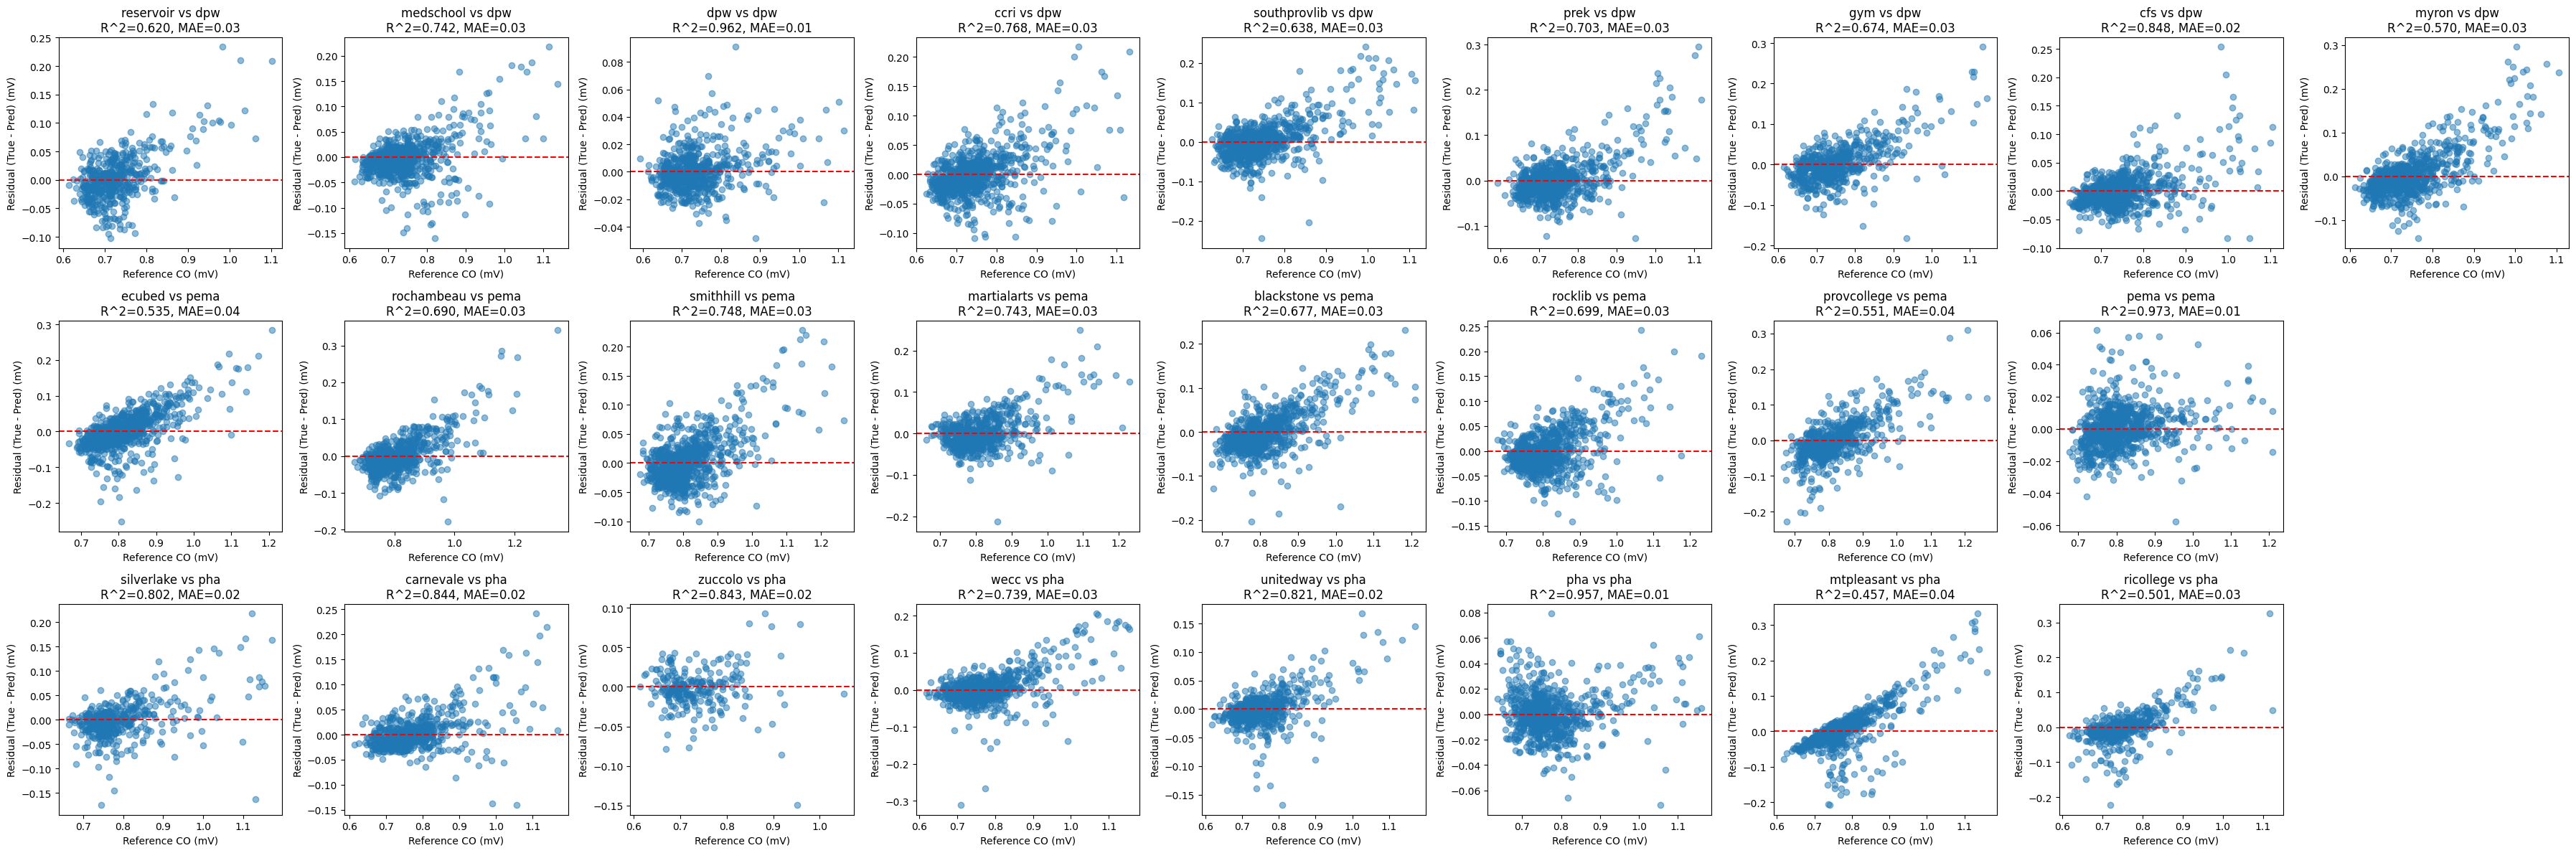

,Reference,Measurement,Determination R^2,Correlation r,RMSE,MAE,Intercept,co_coef,temp_coef,rh_coef,n
0,dpw,reservoir,0.6200,0.7888,0.0415,0.0297,0.7001,0.8370,-0.0039,-0.0013,483.0
1,dpw,medschool,0.7422,0.8641,0.0384,0.0253,0.6439,0.8538,-0.0024,-0.0011,738.0
2,dpw,dpw,0.9617,0.9809,0.0148,0.0104,0.7406,1.1747,-0.0061,-0.0012,655.0
3,dpw,ccri,0.7682,0.8766,0.0373,0.0260,0.6371,1.1453,-0.0028,-0.0014,808.0
4,dpw,southprovlib,0.6377,0.7993,0.0467,0.0311,0.6698,0.8937,-0.0028,-0.0016,840.0
5,dpw,prek,0.7029,0.8391,0.0425,0.0281,0.6306,1.3753,-0.0036,-0.0016,840.0
6,dpw,gym,0.6745,0.8232,0.0477,0.0328,0.7080,0.7598,-0.0040,-0.0014,636.0
7,dpw,cfs,0.8481,0.9215,0.0301,0.0199,0.6567,1.1095,-0.0033,-0.0009,840.0
8,dpw,myron,0.5697,0.7595,0.0511,0.0332,0.6525,0.6729,-0.0023,-0.0006,836.0
9,pema,ecubed,0.5353,0.7320,0.0512,0.0369,0.7902,0.6159,-0.0038,-0.0010,837.0


In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

zones = {
    "dpw" : ["reservoir", "medschool", "dpw", "ccri", "southprovlib", "prek", "gym", "cfs", "myron"],
    "pema" : ["ecubed", "rochambeau", "smithhill", "martialarts", "blackstone", "rocklib", "provcollege", "pema"],
    "pha" : ["silverlake", "carnevale", "zuccolo", "wecc", "unitedway", "pha", "mtpleasant", "ricollege"]
}

dist_models = {ref_site : {meas_site : LinearRegression() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
X_train = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_train = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}

X_test_lt_rsd = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test_lt_rsd = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_pred_lt_rsd = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}

test_times_lt_10pc_rsd = {ref_site : {meas_site : pd.Series() for meas_site in zones[ref_site]} for ref_site in zones.keys()}

# Changed from: drop_cols = ["timestamp", "co_corrected"]
drop_cols = ["timestamp", "co"]

for ref_site in zones.keys():
    for meas_site in zones[ref_site]:
        # Get the indices for train/test split based on the available timestamps for this measurement site
        train_indxs, test_indxs = train_test_split(range(len(meas_times_rsd_lt_10pc[meas_site])), random_state=0)
        
        # Select the timestamps for train/test
        train_times = meas_times_rsd_lt_10pc[meas_site].iloc[train_indxs]
        test_times = meas_times_rsd_lt_10pc[meas_site].iloc[test_indxs]
        test_times_lt_10pc_rsd[ref_site][meas_site] = test_times
        
        # Select the measurement data for train/test, dropping timestamp column
        X_train[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(train_times)].set_index("timestamp")
        X_test_lt_rsd[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(test_times)].set_index("timestamp")
        # X_train[ref_site][meas_site] = measurement_df[meas_site][train_times]
        # X_test_lt_rsd

        X_train[ref_site][meas_site] = X_train[ref_site][meas_site][["co_corrected", "temp", "rh"]]
        X_test_lt_rsd[ref_site][meas_site] = X_test_lt_rsd[ref_site][meas_site][["co_corrected", "temp", "rh"]]

        # Select the reference data for train/test, matching timestamps
        y_train[ref_site][meas_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(train_times)].set_index("timestamp")["co"]
        y_test_lt_rsd[ref_site][meas_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(test_times)].set_index("timestamp")["co"]
        
        dist_models[ref_site][meas_site].fit(X_train[ref_site][meas_site], y_train[ref_site][meas_site])
        y_pred_lt_rsd[ref_site][meas_site] = pd.Series(
            dist_models[ref_site][meas_site].predict(X_test_lt_rsd[ref_site][meas_site]),
            index=y_test_lt_rsd[ref_site][meas_site].index
        )

plot_zones(zones, dist_models, y_test_lt_rsd, y_pred_lt_rsd)

Test the trained models on timestamps outsite of the RSD(co)<0.10 set (i.e. RSD(co)>0.10).

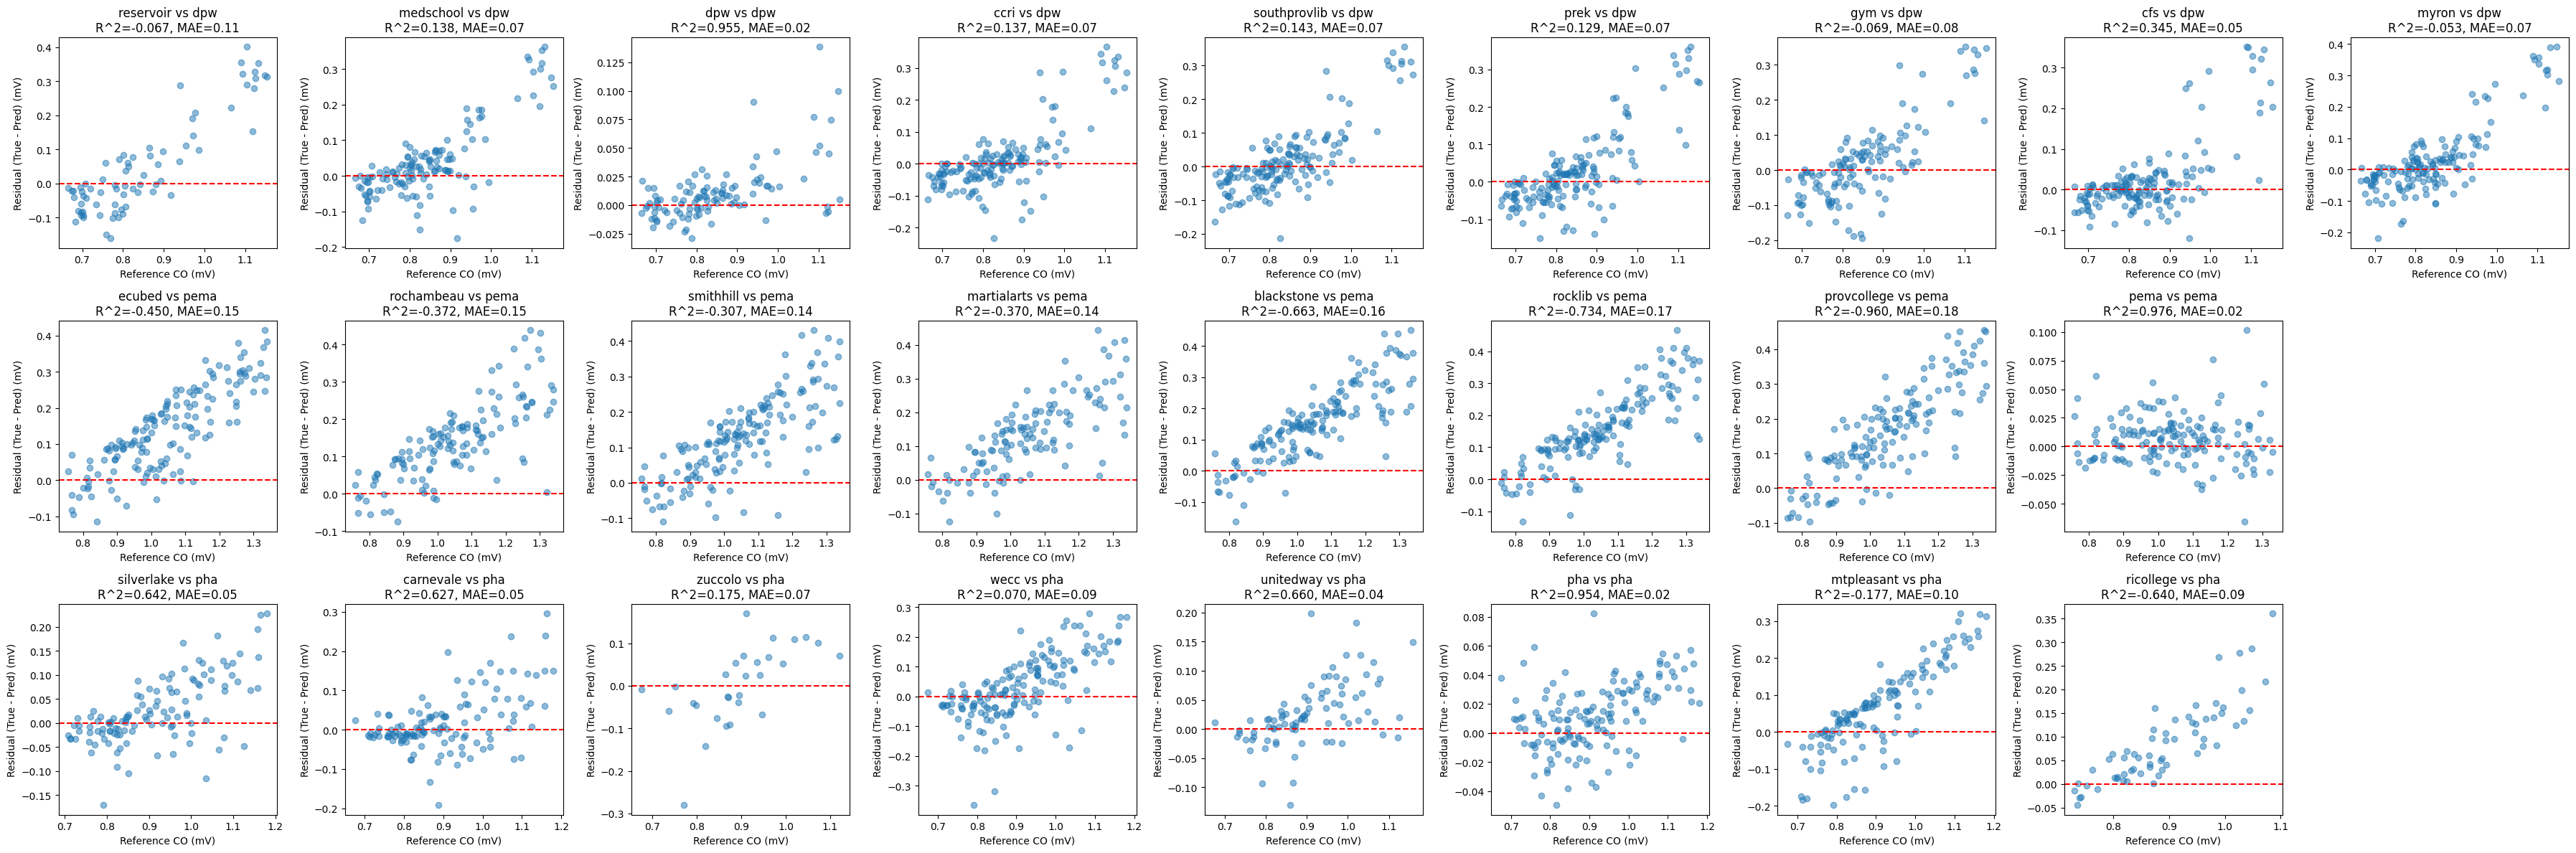

,Reference,Measurement,Determination R^2,Correlation r,RMSE,MAE,Intercept,co_coef,temp_coef,rh_coef,n
0,dpw,reservoir,-0.0673,0.2753,0.1484,0.1058,0.7001,0.8370,-0.0039,-0.0013,73.00
1,dpw,medschool,0.1380,0.5056,0.1093,0.0711,0.6439,0.8538,-0.0024,-0.0011,130.00
2,dpw,dpw,0.9552,0.9843,0.0268,0.0166,0.7406,1.1747,-0.0061,-0.0012,107.00
3,dpw,ccri,0.1374,0.4560,0.1051,0.0664,0.6371,1.1453,-0.0028,-0.0014,149.00
4,dpw,southprovlib,0.1430,0.4425,0.1035,0.0688,0.6698,0.8937,-0.0028,-0.0016,155.00
5,dpw,prek,0.1295,0.4638,0.1060,0.0699,0.6306,1.3753,-0.0036,-0.0016,156.00
6,dpw,gym,-0.0695,0.3127,0.1156,0.0813,0.7080,0.7598,-0.0040,-0.0014,128.00
7,dpw,cfs,0.3449,0.6298,0.0919,0.0515,0.6567,1.1095,-0.0033,-0.0009,156.00
8,dpw,myron,-0.0535,0.3091,0.1166,0.0745,0.6525,0.6729,-0.0023,-0.0006,149.00
9,pema,ecubed,-0.4500,0.6474,0.1801,0.1483,0.7902,0.6159,-0.0038,-0.0010,151.00


In [31]:
X_test_gt_10pc_rsd = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test_gt_10pc_rsd = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test_pred_gt_10pc_rsd = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}

test_times_gt_10pc_rsd = {ref_site : {meas_site : pd.Series() for meas_site in zones[ref_site]} for ref_site in zones.keys()}

for ref_site in zones.keys():
    for meas_site in zones[ref_site]:
        
        test_times = meas_times_rsd_gt_10pc[meas_site] 
        test_times_gt_10pc_rsd[ref_site][meas_site] = test_times

        X_test_gt_10pc_rsd[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(test_times)].set_index("timestamp")[['co_corrected', 'temp', 'rh']]
        y_test_gt_10pc_rsd[ref_site][meas_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(test_times)].set_index("timestamp")["co"]
        y_test_pred_gt_10pc_rsd[ref_site][meas_site] = pd.Series(
            dist_models[ref_site][meas_site].predict(X_test_gt_10pc_rsd[ref_site][meas_site]), 
            index=y_test_gt_10pc_rsd[ref_site][meas_site].index
        )

plot_zones(zones, dist_models, y_test_gt_10pc_rsd, y_test_pred_gt_10pc_rsd)

Test the trained models on calibrated BEACO2N CO data.

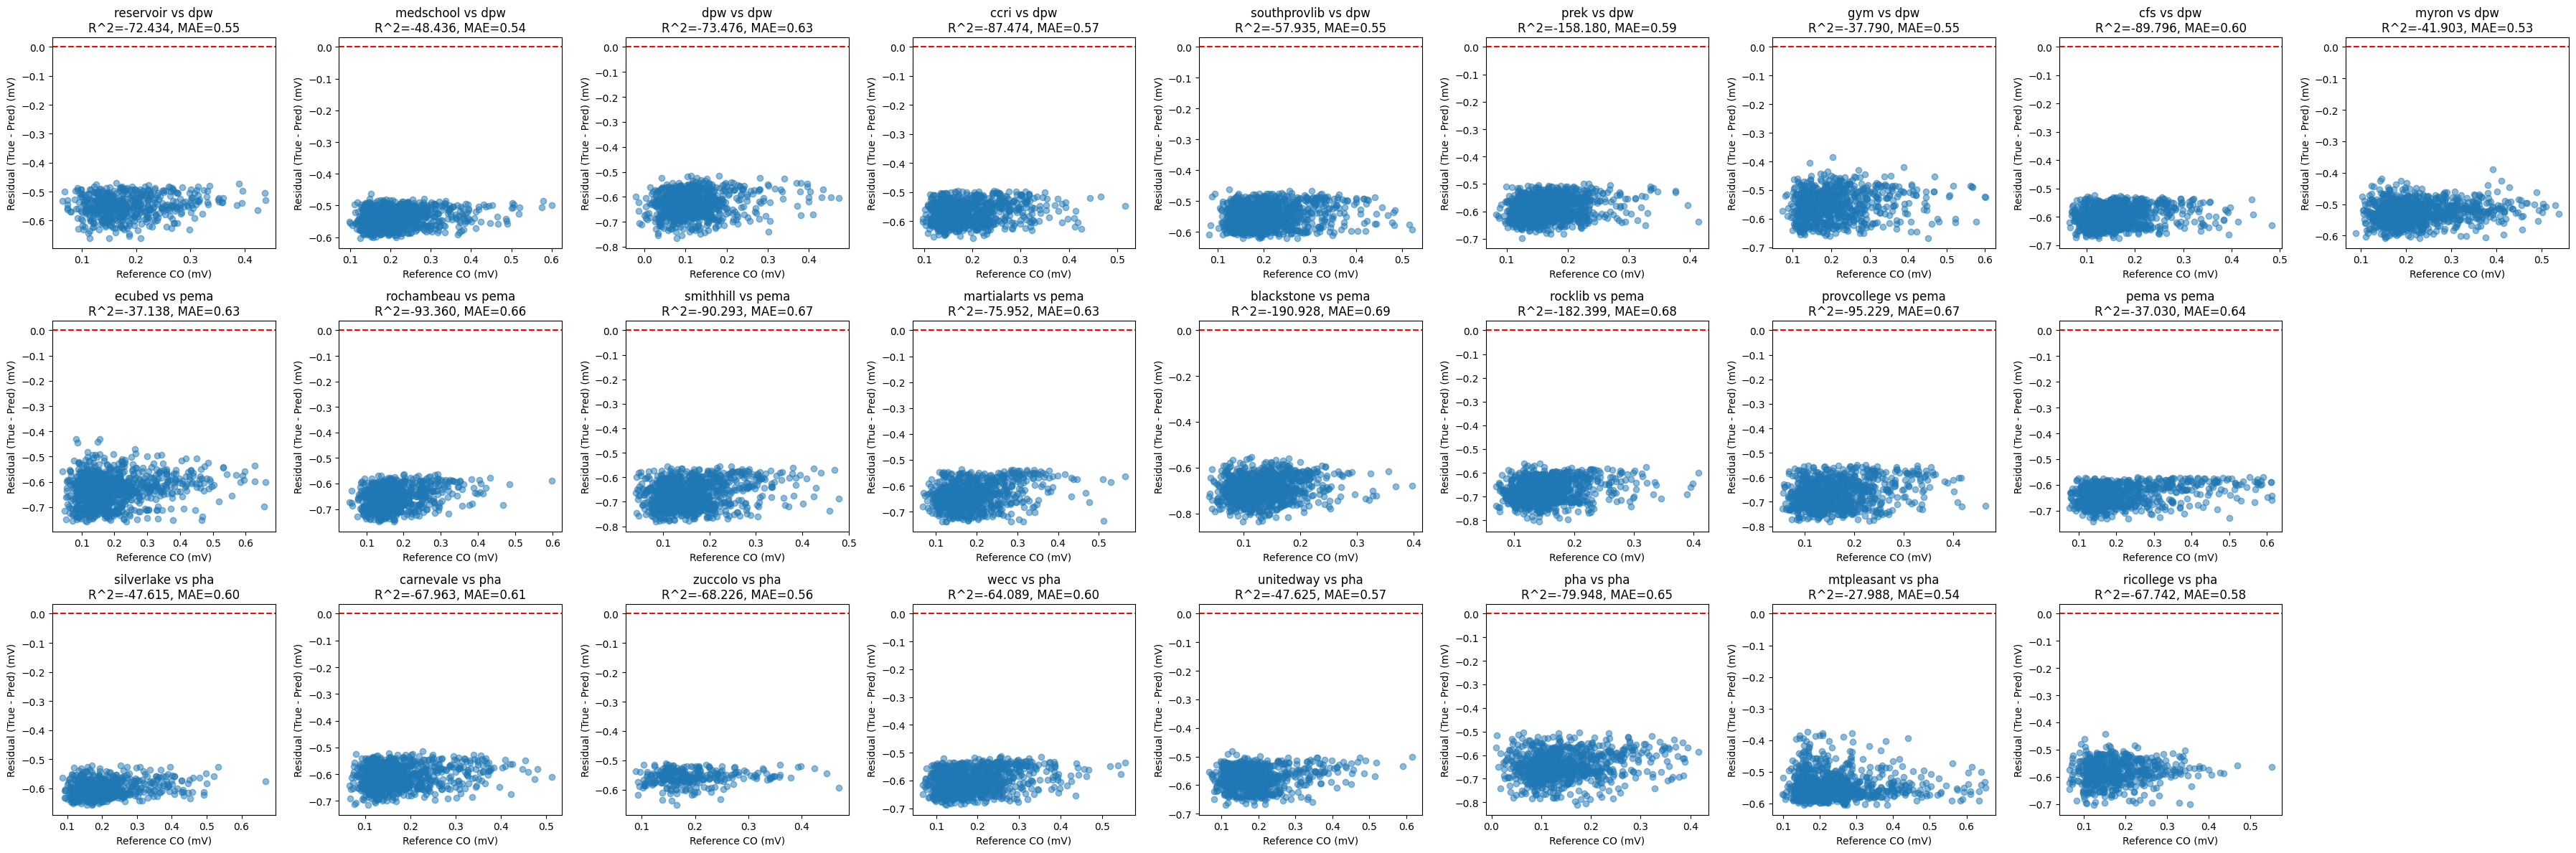

,Reference,Measurement,Determination R^2,Correlation r,RMSE,MAE,Intercept,co_coef,temp_coef,rh_coef,n
0,dpw,reservoir,-72.4340,0.2952,0.5514,0.5500,0.7001,0.8370,-0.0039,-0.0013,556.00
1,dpw,medschool,-48.4362,0.2852,0.5389,0.5382,0.6439,0.8538,-0.0024,-0.0011,868.00
2,dpw,dpw,-73.4761,0.3106,0.6300,0.6281,0.7406,1.1747,-0.0061,-0.0012,762.00
3,dpw,ccri,-87.4742,0.3333,0.5737,0.5726,0.6371,1.1453,-0.0028,-0.0014,957.00
4,dpw,southprovlib,-57.9355,0.3425,0.5496,0.5484,0.6698,0.8937,-0.0028,-0.0016,995.00
5,dpw,prek,-158.1799,0.2608,0.5909,0.5896,0.6306,1.3753,-0.0036,-0.0016,996.00
6,dpw,gym,-37.7904,0.3418,0.5557,0.5533,0.7080,0.7598,-0.0040,-0.0014,764.00
7,dpw,cfs,-89.7955,0.2909,0.5996,0.5986,0.6567,1.1095,-0.0033,-0.0009,996.00
8,dpw,myron,-41.9030,0.2894,0.5276,0.5265,0.6525,0.6729,-0.0023,-0.0006,985.00
9,pema,ecubed,-37.1379,0.4410,0.6346,0.6319,0.7902,0.6159,-0.0038,-0.0010,988.00


In [32]:
X_test_calib_co = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test_calib_co = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_pred_calib_co = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}

for ref_site in zones.keys():
    for meas_site in zones[ref_site]:
        X_test_calib_co[ref_site][meas_site] = pd.concat([
            X_test_lt_rsd[ref_site][meas_site], 
            X_test_gt_10pc_rsd[ref_site][meas_site]
        ], axis=0)

        y_pred_calib_co[ref_site][meas_site] = pd.concat([
            pd.Series(y_pred_lt_rsd[ref_site][meas_site]),
            pd.Series(y_test_pred_gt_10pc_rsd[ref_site][meas_site])
        ], axis=0)

        y_test_calib_co_times = pd.concat([
            test_times_lt_10pc_rsd[ref_site][meas_site],
            test_times_gt_10pc_rsd[ref_site][meas_site]
        ], axis=0)

        y_test_calib_co[ref_site][meas_site] = \
            measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(y_test_calib_co_times)] \
                .set_index("timestamp", drop=True).reindex(y_test_calib_co_times).set_index(y_test_calib_co_times)["co_corrected"]
        

plot_zones(zones, dist_models, y_test_calib_co, y_pred_calib_co)


### Precision-Accuracy calibration
For every zone, we let the BEACO2N sensor that is colocated with reference to be M1 (Measurement_1). We then train a model for each non-colocated sensor Mn (model Pn) to predict M1's CO measurement, and we then train an accuracy model to predict R (Reference) CO data given M1 CO data. 

In [33]:
# Find times within a zone when RSD(co)<0.10 for all sites
rsd_pa = {ref_site : [] for ref_site in zones.keys()}
ref_times_lt_rsd = {ref_site : pd.DataFrame() for ref_site in zones.keys()}
zone_times_lt_rsd = {ref_site : {meas_site : pd.Series() for meas_site in zones[ref_site]} for ref_site in zones.keys()}

for ref_site in zones.keys():
    rsd_pa[ref_site].append(reference_df[ref_site][["timestamp","co"]].rename(columns={"co":f"{ref_site}_ref"}))
    for meas_site in zones[ref_site]: 
        rsd_pa[ref_site].append(measurement_df[meas_site][["timestamp","co"]].rename(columns={"co":meas_site}))

    rsd_pa[ref_site][0] = reduce(lambda table, to_merge: pd.merge(table, to_merge, on="timestamp", how="inner"), rsd_pa[ref_site])
    rsd_pa[ref_site][0]["rsd"] = rsd_pa[ref_site][0].apply(rsd, axis=1)
    rsd_pa[ref_site][1] = rsd_pa[ref_site][0][rsd_pa[ref_site][0]["rsd"]>=1.20]["timestamp"]
    rsd_pa[ref_site][0] = rsd_pa[ref_site][0][rsd_pa[ref_site][0]["rsd"]<1.20]["timestamp"]
    if len(rsd_pa[ref_site])>2: rsd_pa[ref_site][2:].clear()
    
    for meas_site in zones[ref_site]: 
        zone_times_lt_rsd[ref_site][meas_site] = rsd_pa[ref_site][0]

        # Set zone_times_lt_rsd to be the set of timestamps for measurements in measurement_df[meas_site] that occured at times when the RSD(co) within the zone was less than 1.20
        zone_times_lt_rsd[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(zone_times_lt_rsd[ref_site][meas_site])]["timestamp"]


In [34]:
# Plotting function for accuracy models:
from sklearn.metrics import mean_absolute_error, r2_score

def plot_accuracy_models(zones, accuracy_model, y_test_a_lt, y_pred_a_lt):
    import matplotlib.pyplot as plt

    num_refsites = len(zones)
    fig, axes = plt.subplots(1, num_refsites, figsize=(4*num_refsites, 4), squeeze=False)
    statistics = []

    for col, ref_site in enumerate(zones.keys()):
        y_true = y_test_a_lt[ref_site]
        y_pred = y_pred_a_lt[ref_site]
        if len(y_true) == 0 or len(y_pred) == 0:
            axes[0][col].set_visible(False)
            continue
        residual = y_true - y_pred
        axes[0][col].scatter(y_true, residual, alpha=0.5)
        axes[0][col].axhline(0, color='red', linestyle='--')
        axes[0][col].set_title(f"{ref_site} Accuracy Model\nR^2={r2_score(y_true, y_pred):.3f}, MAE={mean_absolute_error(y_true, y_pred):.2f}")
        axes[0][col].set_xlabel("Reference CO (mV)")
        axes[0][col].set_ylabel("Residual (True - Pred) (mV)")

        model = accuracy_model[ref_site]
        statistics.append({
            "Reference": ref_site,
            "Determination R^2": r2_score(y_true, y_pred),
            "Correlation r": np.corrcoef(y_true, y_pred)[0, 1],
            "RMSE": sqrt(np.mean((y_true - y_pred) ** 2)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "Intercept": model.intercept_,
            "co_coef": model.coef_[0],
            "temp_coef": model.coef_[1],
            "rh_coef": model.coef_[2],
            "n": len(y_true)
        })

    plt.tight_layout()
    plt.show()
    display(pd.DataFrame(statistics).round(4))


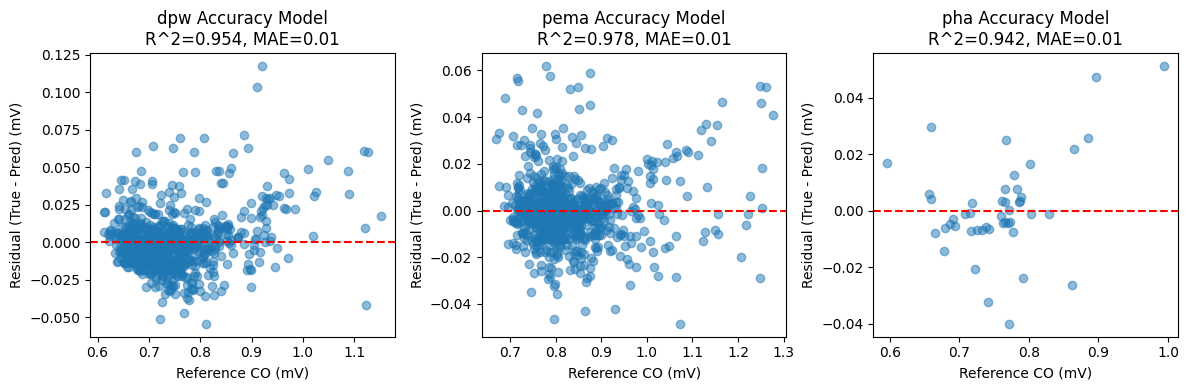

,Reference,Determination R^2,Correlation r,RMSE,MAE,Intercept,co_coef,temp_coef,rh_coef,n
0,dpw,0.9538,0.9767,0.0182,0.0125,0.7042,0.0019,-0.0032,-0.0012,791
1,pema,0.9781,0.9890,0.0145,0.0103,0.7325,0.0021,-0.0034,-0.0009,796
2,pha,0.9416,0.9710,0.0171,0.0117,0.6073,0.0019,-0.0006,-0.0000,46


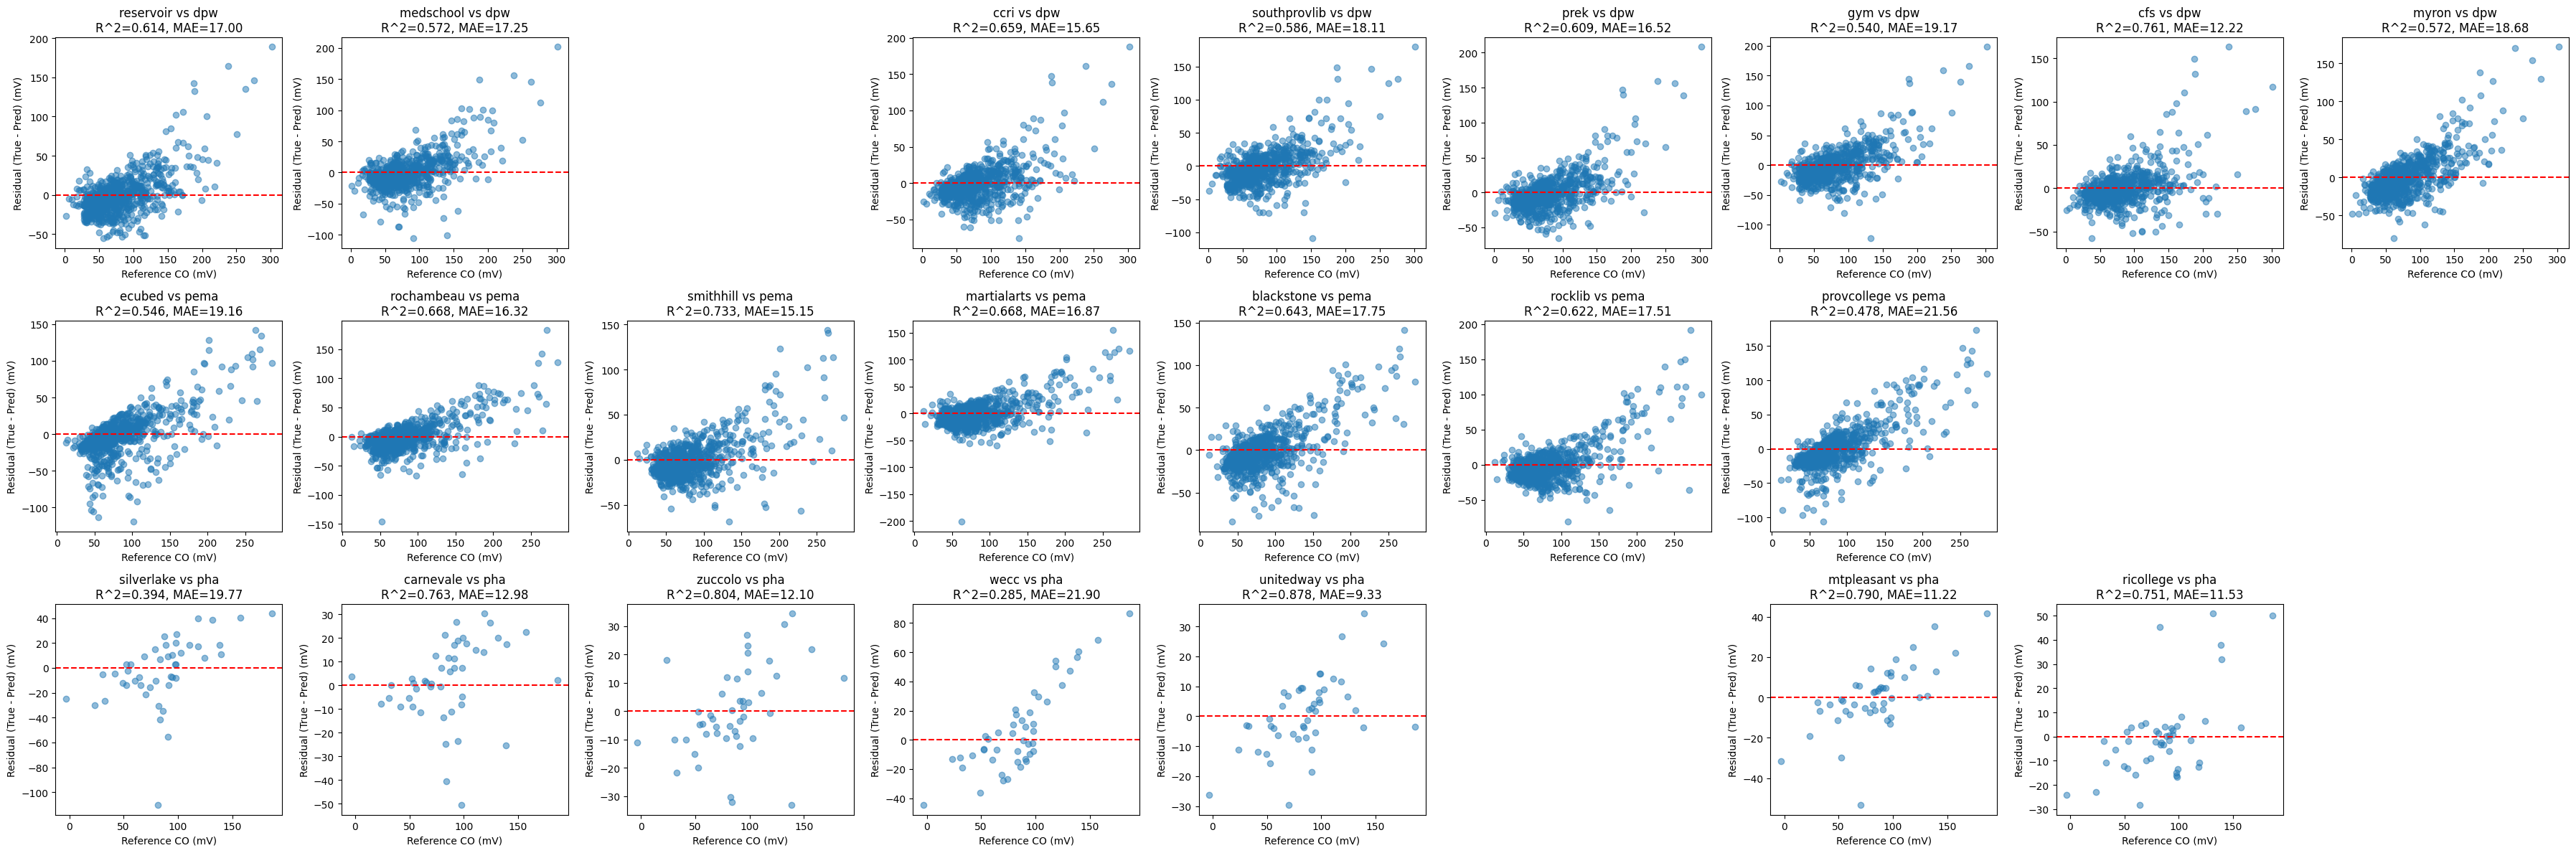

,Reference,Measurement,Determination R^2,Correlation r,RMSE,MAE,Intercept,co_coef,temp_coef,rh_coef,n
0,dpw,reservoir,0.6137,0.7838,25.2566,16.9958,46.1069,0.8626,-0.8051,-0.1067,791.0000
1,dpw,medschool,0.5722,0.7594,26.5796,17.2465,14.8941,0.7568,-0.7794,0.0553,791.0000
2,dpw,ccri,0.6593,0.8131,23.7179,15.6450,2.1806,0.9845,-0.8294,-0.1396,791.0000
3,dpw,southprovlib,0.5861,0.7694,26.1445,18.1069,33.1057,0.7730,-0.8533,-0.1161,791.0000
4,dpw,prek,0.6095,0.7813,25.3937,16.5151,-18.6106,1.0066,-0.8802,-0.1829,791.0000
5,dpw,gym,0.5400,0.7372,27.5616,19.1669,15.7599,0.7557,-0.9413,-0.1102,791.0000
6,dpw,cfs,0.7612,0.8728,19.8580,12.2195,19.7549,1.0006,-0.3647,0.0557,791.0000
7,dpw,myron,0.5717,0.7575,26.5952,18.6816,1.8457,0.7170,-0.0898,0.2597,791.0000
8,pema,ecubed,0.5463,0.7434,28.8835,19.1560,21.2479,0.6919,-0.3115,0.0906,796.0000
9,pema,rochambeau,0.6683,0.8203,24.6976,16.3197,12.3715,1.0292,-0.4942,0.0610,796.0000


In [35]:
precision_model = {ref_site : {meas_site : LinearRegression() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
accuracy_model = {ref_site : LinearRegression() for ref_site in zones.keys()}

X_train_p = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_train_p = {ref_site : {meas_site : pd.Series() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
X_train_a = {ref_site : pd.DataFrame() for ref_site in zones.keys()}
y_train_a = {ref_site : pd.Series() for ref_site in zones.keys()}

X_test_p_lt = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test_p_lt = {ref_site : {meas_site : pd.Series() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_pred_p_lt = {ref_site : {meas_site : pd.Series() for meas_site in zones[ref_site]} for ref_site in zones.keys()}

X_test_a_lt = {ref_site : pd.DataFrame() for ref_site in zones.keys()}
y_test_a_lt = {ref_site : pd.Series() for ref_site in zones.keys()}
y_pred_a_lt = {ref_site : pd.Series() for ref_site in zones.keys()}

for ref_site in zones.keys():
    for meas_site in zones[ref_site]:
        if meas_site == ref_site: continue

        train_indxs, test_indxs = train_test_split(range(len(zone_times_lt_rsd[ref_site][meas_site])), random_state=0, test_size=0.4)
        train_times = zone_times_lt_rsd[ref_site][meas_site].iloc[train_indxs].sort_index()
        test_times = zone_times_lt_rsd[ref_site][meas_site].iloc[test_indxs].sort_index()


        X_train_p[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(train_times)][["co", "temp", "rh"]]
        X_test_p_lt[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(test_times)][["co", "temp", "rh"]]

        y_train_p[ref_site][meas_site] = measurement_df[ref_site][measurement_df[ref_site]["timestamp"].isin(train_times)]["co"]
        y_test_p_lt[ref_site][meas_site] = measurement_df[ref_site][measurement_df[ref_site]["timestamp"].isin(test_times)]["co"]

        precision_model[ref_site][meas_site].fit(X_train_p[ref_site][meas_site], y_train_p[ref_site][meas_site])
        y_pred_p_lt[ref_site][meas_site] = precision_model[ref_site][meas_site].predict(X_test_p_lt[ref_site][meas_site]) # type: ignore

    X_train_a[ref_site] = measurement_df[ref_site][measurement_df[ref_site]["timestamp"].isin(train_times)][["co", "temp", "rh"]]
    X_test_a_lt[ref_site] = measurement_df[ref_site][measurement_df[ref_site]["timestamp"].isin(test_times)][["co", "temp", "rh"]]
    y_train_a[ref_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(train_times)]["co"]
    y_test_a_lt[ref_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(test_times)]["co"]
    accuracy_model[ref_site].fit(X_train_a[ref_site], y_train_a[ref_site])
    y_pred_a_lt[ref_site] = accuracy_model[ref_site].predict(X_test_a_lt[ref_site]) # type: ignore
    
plot_accuracy_models(zones, accuracy_model, y_test_a_lt, y_pred_a_lt)
plot_zones(zones, precision_model, y_test_p_lt, y_pred_p_lt)


Leave-one-out cross validation approach for p-a models: (since there is limited data for pha zone)